In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_absolute_error as mae

%matplotlib inline

In [3]:
df = pd.read_csv('/Users/jubmam/Desktop/Metis/Project_2/dfgiga_covid.csv')
dftwo = pd.read_csv('/Users/jubmam/Desktop/Metis/Project_2/Emergency.csv')
dfthree = pd.read_csv('/Users/jubmam/Desktop/Metis/Project_2/Urban.csv')
dffour = pd.read_csv('/Users/jubmam/Desktop/Metis/Project_2/PopulationClean.csv')
df = pd.concat([df, dftwo, dfthree, dffour], axis = 1)
df['Population Over 85'] = df['Population Over 85']/df['Population']
df = df.drop(['Unnamed: 0', 'Population Density', 'Median Household Income (2019', 'Population', 'Nonwhite Population'], axis = 1)
df = df.rename(columns={'RUCC_2013' : 'Urban Index', 
                        'Population Over 85': 'Population Over 85 Ratio', 
                        'Dem Rep Margin': 'Dem-Rep Voter %'})

df = df.sample(frac=1).reset_index(drop=True)

In [4]:
maskTex = df['State'] == 'Texas'
df.loc[maskTex, 'Dem-Rep Voter %'] = df['Dem-Rep Voter %'] * (-1)

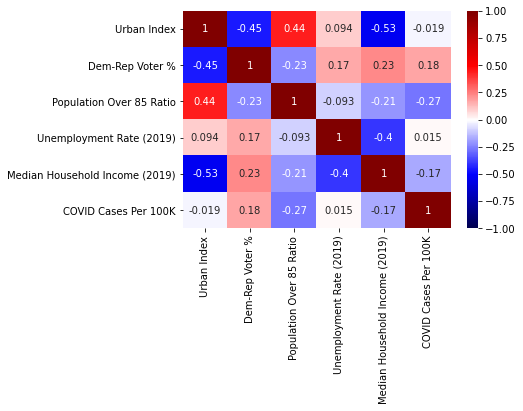

In [5]:
newcol = []
col = df.columns.tolist()
newcol = [col[0], col[1], col[7], col[2], col[3], col[4], col[6], col[5]]
col = newcol
df = df[col]
sns.heatmap(df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

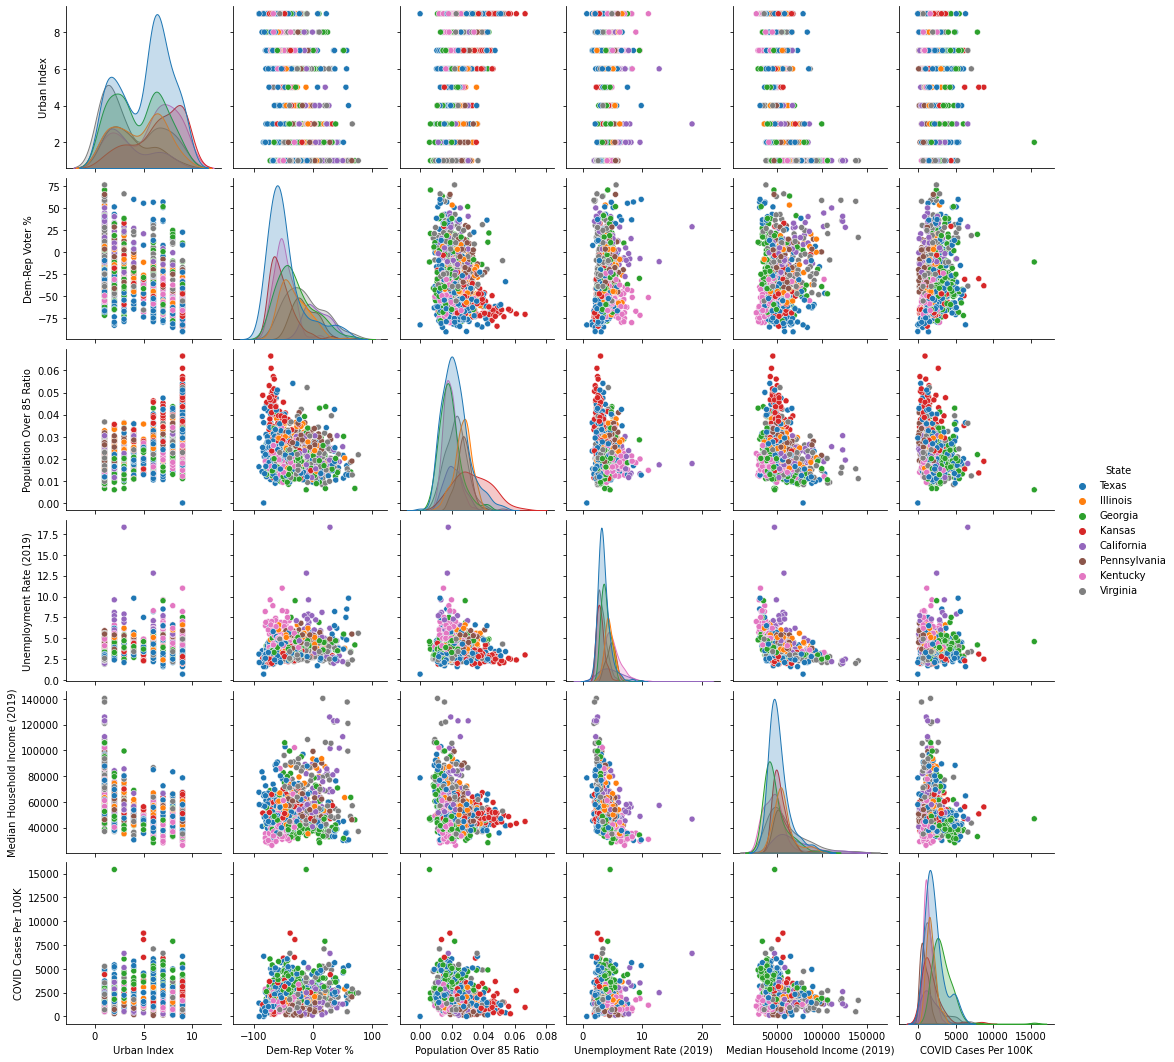

In [6]:
mask = ((df['COVID Cases Per 100K'] < 10000) & 
        (df['Unemployment Rate (2019)'] < 10))

dfmask = df[mask]

sns.pairplot(df, hue="State", palette = 'tab10')



In [7]:
dfmask = dfmask.rename(columns={'Urban Index': 'X1',
                        'Dem-Rep Voter %': 'X2', 
                        'Population Over 85 Ratio': 'X3',
                        'Unemployment Rate (2019)': 'X4',
                        'Median Household Income (2019)': 'X5',
                        'COVID Cases Per 100K': 'Y'})

y, X = patsy.dmatrices('Y ~ X1 + X2 + X3 + X4 + X5', data=dfmask, return_type="dataframe")
lm1 = smf.ols('Y ~ X1 + X2 + X3 + X4 + X5', data=dfmask)
fit1 = lm1.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     52.02
Date:                Sat, 10 Oct 2020   Prob (F-statistic):           5.80e-48
Time:                        10:41:50   Log-Likelihood:                -8401.8
No. Observations:                 994   AIC:                         1.682e+04
Df Residuals:                     988   BIC:                         1.685e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6050.0575    319.706     18.924      0.000    5422.677    6677.438
X1            45.7721     18.166      2.520      0.012      10.124      81.420
X2            10.6385      1.296      8.207      0.000       8.095      13.182
X3         -5.118e+04   4736.824    -10.804      0.000   -6.05e+04   -4.19e+04
X4          -282.0718     34.525     -8.170      0.000    -349.823    -214.321
X5            -0.0311      0.003     -9.822      0.000      -0.037      -0.025
==============================================================================
Omnibus:                      218.033   Durbin-Watson:                   2.114
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              497.045
Skew:                           1.191   Prob(JB):                    1.17e-108
Kurtosis:                       5.515   Cond. No.                     7.22e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.22e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [8]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=36)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=44)

In [9]:
lm = LinearRegression()
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_rig = Ridge(alpha=1)
lm_las = Lasso(alpha=1)

poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_rig.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_rig.score(X_val_scaled, y_val):.3f}')

lm_las.fit(X_train_scaled, y_train)
print(f'Lasso Regression val R^2: {lm_las.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

print(f'Degree 2 polynomial regression coefficients {lm_poly.coef_[0]}')


Linear Regression val R^2: 0.297
Ridge Regression val R^2: 0.297
Lasso Regression val R^2: 0.297
Degree 2 polynomial regression val R^2: 0.324
Degree 2 polynomial regression coefficients [-2.13318653e+01 -1.95390457e+01  2.91055258e+02  1.20113702e+01
 -1.44475818e+05 -5.73550286e+02 -9.24864746e-02 -5.93175946e-05
  2.90835991e+02  1.19752027e+01 -1.44475820e+05 -5.73549085e+02
 -9.50132017e-02 -2.97847855e+01 -6.64681639e-01  1.12433602e+04
 -4.98973944e+01 -6.67681710e-03 -6.59174979e-02 -7.64425741e+01
  1.78803296e+00 -4.06529287e-04  1.10496209e+05  1.09183217e+04
  2.41753017e+00  5.90182920e+01  8.15680152e-03  7.38123972e-07]


In [10]:
lm.fit(X, y)
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

lm_rig.fit(X, y)
print(f'Ridge Regression test R^2: {lm_rig.score(X_test, y_test):.3f}')

lm_las.fit(X, y)
print(f'Lasso Regression test R^2: {lm_las.score(X_test, y_test):.3f}')

lm.fit(X, y)
print(f'Degree 2 polynomial regression test R^2: {lm_poly.score(X_test_poly, y_test):.3f}')

Linear Regression test R^2: 0.130
Ridge Regression test R^2: 0.078
Lasso Regression test R^2: 0.127
Degree 2 polynomial regression test R^2: 0.243


In [13]:
list(zip(poly.get_feature_names(X_train.columns), lm_poly.coef_))

[('1',
  array([-2.13318653e+01, -1.95390457e+01,  2.91055258e+02,  1.20113702e+01,
         -1.44475818e+05, -5.73550286e+02, -9.24864746e-02, -5.93175946e-05,
          2.90835991e+02,  1.19752027e+01, -1.44475820e+05, -5.73549085e+02,
         -9.50132017e-02, -2.97847855e+01, -6.64681639e-01,  1.12433602e+04,
         -4.98973944e+01, -6.67681710e-03, -6.59174979e-02, -7.64425741e+01,
          1.78803296e+00, -4.06529287e-04,  1.10496209e+05,  1.09183217e+04,
          2.41753017e+00,  5.90182920e+01,  8.15680152e-03,  7.38123972e-07]))]

In [25]:
import yellowbrick
from yellowbrick.regressor import ResidualsPlot

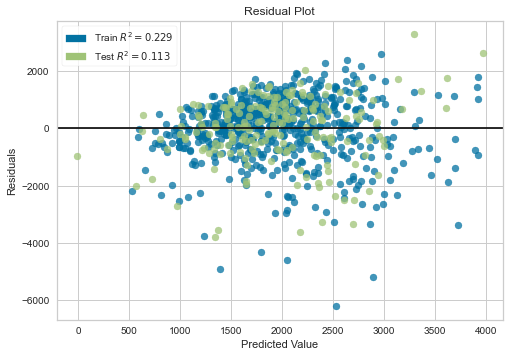

<AxesSubplot:title={'center':'Residual Plot'}, xlabel='Predicted Value', ylabel='Residuals'>

In [39]:
visualizer = ResidualsPlot(model, hist = False, title="Residual Plot", )
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

In [13]:
from sklearn.metrics import r2_score,mean_absolute_error as mae, mean_squared_error as rmse
y_val_pred = lm.predict(X_test)
r2_score(y_test,y_val_pred)
mae(y_test, y_val_pred)

905.0455021963327